In [3]:
from __future__ import division

import math, os, json, sys, re
import multiprocessing as mp
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import PIL
from PIL import Image
from numpy.random import random, permutation, randn, normal, uniform, choice
from numpy import newaxis
import scipy
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread
from sklearn.metrics import confusion_matrix

os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib


# from alexnet import AlexNet_base
# import theano
import tensorflow as tf

keras.backend.set_image_dim_ordering('tf')

/home/okon/anaconda2/envs/newtf3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# train_dir = '/beegfs/general/okon/Downloads/train/'
# test_dir = '/beegfs/general/okon/Downloads/test1/'

# weights_path = '/beegfs/general/okon/Downloads/alexnetsvm/data/alexnet_weights.h5'

train_dir = '/beegfs/general/okon/Downloads/train/'
val_dir = './val/'
test_dir = '/beegfs/general/okon/Downloads/test1/'


# weights_path = './alexnet_weights.h5'

In [5]:
img_size=331

def preprocess_input(x):
    # use this to process input, set to pass if no processing required.
    return keras.applications.nasnet.preprocess_input(np.array(x, dtype=np.float32))
    # pass

# Get all filenames of training and test data:
def get_data_dict(directory):
    categories = os.listdir(directory)
    filenames = [os.listdir(os.path.join(directory, cat)) for cat in categories]
    return dict(zip(categories, filenames))

train_data_paths = get_data_dict(train_dir)
test_data_paths = get_data_dict(test_dir)


# load image by id without augmentations
def preprocess_image_worker(path):
    img = Image.open(path).convert('RGB')
    img = img.resize((img_size, img_size))

    x = image.img_to_array(img)
    if keras.backend.backend() == 'theano':
        x = np.reshape(x, (3, img_size, img_size))
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x) # preprocessing is done my the alexnet model
    return x

# load image by id with augmentations
def preprocess_image_worker_aug(path):
    img = Image.open(path).convert('RGB')
    img = img.crop((int(np.random.uniform(0, 0.05)*img.width), int(np.random.uniform(0, 0.05)*img.height),
                  int(np.random.uniform(0.95, 1.)*img.width), int(np.random.uniform(0.95, 1.)*img.height)))
    if np.random.randint(2) == 0:
        img = img.transpose(np.random.choice([PIL.Image.FLIP_LEFT_RIGHT, PIL.Image.FLIP_TOP_BOTTOM, PIL.Image.ROTATE_90, PIL.Image.ROTATE_180, PIL.Image.ROTATE_270, PIL.Image.TRANSPOSE]))
    img = img.resize((img_size, img_size))

    x = image.img_to_array(img)
    if keras.backend.backend() == 'theano':
        x = np.reshape(x, (3, img_size, img_size))
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # preprocessing is done my the alexnet model
    return x

# data generator, divides list images into mini-batches
def batch_generator_predict(pool, batch_size, images):
    i = 0
    while True:
        batch = images[i: (i+batch_size)]
        i += batch_size
        if len(batch) == 0:
            i=0
            continue
            # yield np.zeros((0, 3, img_size, img_size)), np.zeros(len(batch))
        else:
            result = pool.map(preprocess_image_worker, batch)
            X_batch = np.concatenate(result, axis=0)
            yield X_batch, np.zeros(len(batch))

In [6]:
class Sampler:
    def __init__(self, pool, batch_size, num_samples, mode='semihard', dataset=train_data_paths, data_root=train_dir):
        self.pool = pool # nultithreading pool
        self.batch_size = batch_size # the batch size during training
        self.num_samples = num_samples # the number of images to load at once
        self.mode = mode # mode, either 'semigard' or 'hard' negative samples
        self.dataset = dataset # data path dict to use
        self.data_root = data_root # the root directory of data to use

        self.resample()

    # sample triplets with semi-hard negatives
    def resample(self):
        categories = list(self.dataset.keys()) # get the strings  'c0', 'c1', ...
        num_images_by_class = [len(self.dataset[c]) for c in categories] # number of images in each category
        num_images_by_class = np.array(num_images_by_class)

        sample_classes = np.random.choice(range(len(categories)), p=num_images_by_class/sum(num_images_by_class), size=self.num_samples)

        sample_images = [] # this is just a list of image paths
        for i in sample_classes:
            cat = categories[i] # the category string

            # grab 2 images from this category:
            image_indices = np.random.choice(range(num_images_by_class[i]), size=2, replace=False)

            # convert those 2 images to filepaths
            image_paths = [os.path.join(self.data_root, cat, self.dataset[cat][img_idx]) for img_idx in image_indices]

            sample_images += image_paths

        sample_images = np.array(sample_images)
    
        if self.mode == 'random': # randomly select negative sample
            triplets = []
            for i in range(self.num_samples):
                neg_sample_classes = (sample_classes != sample_classes[i]).nonzero()[0]
                neg_ids = sample_images.reshape((-1, 2))[neg_sample_classes, 1]
                n = np.random.choice(range(len(neg_sample_classes)))
                triplets.append(np.concatenate([sample_images.reshape((-1, 2))[i], np.array([neg_ids[n]])]))
        
        else: # do forward pass to get negative sample
            pred_sample = model.predict_generator(batch_generator_predict(self.pool, self.batch_size, sample_images),
                                                  math.ceil(len(sample_images)//self.batch_size), max_queue_size=1, workers=1)

            # since we added samples 2 at a time, a and p are of the same category
            a = pred_sample[np.arange(0, len(pred_sample), 2)]
            p = pred_sample[np.arange(1, len(pred_sample), 2)]

            triplets = []
            self.dists = []
            for i in range(self.num_samples):
                d = np.square(a[i] - p[i]).sum()

                neg_sample_classes = (sample_classes != sample_classes[i]).nonzero()[0]

                neg = p[neg_sample_classes]

                neg_ids = sample_images.reshape((-1, 2))[neg_sample_classes, 1]

                d_neg = np.square(neg - a[i]).sum(axis=1)

                # choose either hard or semihard negative examples
                if self.mode == 'hard':
                    n = np.argmin(d_neg)

                elif self.mode == 'semihard':
                    semihard = np.where(d_neg > d)[0]
    
                    if len(semihard) == 0 or (1%3==0):
                        n = np.argmax(d_neg)
                    else:
                        n = semihard[np.argmin(d_neg[semihard])]

                self.dists.append(d_neg[n]-d)

                triplets.append(np.concatenate([sample_images.reshape((-1, 2))[i], np.array([neg_ids[n]])]))

        self.triplets = np.array(triplets)
        
    # data generator for triplets
    def batch_generator(self):
        i = 0
        while True:
            batch = self.triplets[i:(i+self.batch_size//3)].ravel()
            i += self.batch_size//3
            if len(batch) == 0:
                i=0
                continue
                # yield np.zeros((0, 3, img_size, img_size)), np.zeros(len(batch))
            else:
                result = self.pool.map(preprocess_image_worker_aug, batch)
                #print(result.shape)
                X_batch = np.concatenate(result, axis=0)
                #print(X_batch.shape)

                yield (X_batch, np.zeros(len(batch)))

    # return data generator for triplets
    def get_generator(self):
        gen = self.batch_generator()
        return gen

In [7]:
batch_size = 3*10   # size of mini-batch, must be multiple of 3

# margin triplet loss
def margin_triplet_loss(y_true, y_pred):
    margin = 0.3 # margin for triplet loss
    out_a = K.gather(y_pred, K.arange(0, batch_size, 3))
    out_p = K.gather(y_pred, K.arange(1, batch_size, 3))
    out_n = K.gather(y_pred, K.arange(2, batch_size, 3))

    loss = K.maximum(margin
                 + K.sum(K.square(out_a-out_p), axis=1)
                 - K.sum(K.square(out_a-out_n), axis=1),
                 0)

    # this is a good way to extend triplet loss to include gradient from each triplet.
    return K.mean(loss)

def naive_triplet_loss(y_true, y_pred):
    # distance param
    alpha = 0.3
    
    # predictions made in sets of 3
    out_a = K.gather(y_pred, K.arange(0, batch_size, 3))
    out_p = K.gather(y_pred, K.arange(1, batch_size, 3))
    out_n = K.gather(y_pred, K.arange(2, batch_size, 3))

    # standard squared euclidean dist
    d_ap = K.sum(K.square(out_a-out_p), axis=1)
    d_an = K.sum(K.square(out_a-out_n), axis=1)
    
    #means over batch
    mu_ap = K.mean(d_ap)
    mu_an = K.mean(d_an)
    
    # Standard triplet loss:
    loss = K.maximum(mu_ap - mu_an + alpha, 0.)
    
    # * see note above about why mean should be at the end *
    
    return loss

def batch_triplet_loss(y_true, y_pred):
    # params for loss
    alpha = 0.3
    beta = 0.5
    
    # predictions made in sets of 3
    out_a = K.gather(y_pred, K.arange(0, batch_size, 3))
    out_p = K.gather(y_pred, K.arange(1, batch_size, 3))
    out_n = K.gather(y_pred, K.arange(2, batch_size, 3))

    # standard squared euclidean dist
    d_ap = K.sum(K.square(out_a-out_p), axis=1)
    d_an = K.sum(K.square(out_a-out_n), axis=1)
    
    #means over batch
    mu_ap = K.mean(d_ap)
    mu_an = K.mean(d_an)
    
    # Standard triplet loss:
    #     loss = K.maximum(mu_ap - mu_an + alpha, 0)
    
    # avg. variance:
    sig2_ap = K.mean(K.square(d_ap - mu_ap))
    sig2_an = K.mean(K.square(d_an - mu_an))
    # * this should not be necessary, if mean is left to end,
    #    but it does offer more control of the function...

    # Batch triplet loss formulation:
    loss = (1.-beta)*K.maximum(0., mu_ap - mu_an + alpha) + beta*(sig2_ap + sig2_an)

    return loss

def batch_triplet_loss_online(y_true, y_pred):
    # * online selection of positives and negatives to use
    # ** theoretically better with larger batch sizes
    pass

In [8]:
# from keras.applications import nasnet
# nasnet.NASNetLarge().summary()

In [9]:
# function to move split% of your data to a validataion directory
def build_val(data_root, data_dict, val_root, split=.05):
    join = os.path.join
    if os.path.exists(val_root):
        print('val data already saved. skipping...')
        return
    for key in data_dict.keys():
        os.makedirs(join(val_root, key))
        image_names = data_dict[key]
        val_len = int(len(image_names)*split)
        chosen = image_names[-val_len:]
        for file in chosen:
            os.rename(join(data_root, key, file), join(val_root, key, file))

# recombine val and train data
def recombine(data_root, val_root):
    join = os.path.join
    if not os.path.exists(val_root):
        print('val dir not found. skipping...')
        return
    for _dir in os.listdir(val_root):
        for file in os.listdir(join(val_root, _dir)):
            os.rename(join(val_root, _dir, file), join(data_root, _dir, file))
        os.rmdir(join(val_root, _dir))
    os.rmdir(val_root)

# Function for generating batches
def get_batches(dirname, shuffle=False, batch_size=9,
                class_mode='categorical', target_size=(img_size, img_size)):
    if keras.backend.backend() == 'tensorflow':
        gen=image.ImageDataGenerator(data_format='channels_last', rescale=1./122.5, samplewise_center=True)
    else:
        gen=image.ImageDataGenerator(data_format='channels_first')
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)



In [10]:
# save validation data:
# run recombine as commented out to undo
build_val(train_dir, train_data_paths, val_dir, split=0.3)
#recombine(train_dir, val_dir)

val data already saved. skipping...


In [11]:
from keras.layers import GlobalAveragePooling2D
from keras.utils import multi_gpu_model


def build_nasnet(input_shape=(331, 331, 3), dropout=True,
                    trainable=True, out_dims=128, normalize=True):
    inp = Input(shape=input_shape)
                                      
    
    
    model = keras.applications.nasnet.NASNetLarge(input_shape=input_shape, include_top=True, 
                                                  weights='imagenet', input_tensor=inp, pooling=None)
    
    
    
    
    
    #model = keras.applications.mobilenet.MobileNet(input_shape=input_shape, alpha=1.0, 
                                        #depth_multiplier=1, dropout=1e-3, include_top=True, 
                                        #weights='imagenet',input_tensor=inp, pooling=None)

    for layer in model.layers:
        layer.trainable = trainable

    x = model.layers[-2].output
    
    #x = Flatten()(x)
    
    if dropout:
        x = Dropout(0.4)(x)

    x = Dense(out_dims, name='output')(x)

    if normalize:
        if keras.backend.backend() == 'tensorflow':
            x = Lambda(lambda x: tf.nn.l2_normalize(x, dim=1), name='l2_norm')(x)
        else:
            x = Lambda(lambda x: K.l2_normalize(x, dim=1), name='l2_norm')(x)

    model = Model(inp, x)
    return model

# model = build_nasnet()
# model.compile(optimizer=Adam(lr=0.0001, decay=0.0005),  loss=margin_triplet_loss)
# model.summary()

In [10]:

model_bac = build_nasnet()
model = multi_gpu_model(model_bac, gpus=6)


model.compile(optimizer=Adam(lr=0.0001, decay=0.0005),  loss=margin_triplet_loss)

ver = 'benchmark_nasnet_triplet'
model_path = 'data/models/'+ver+'/'
if not os.path.exists(model_path):
    os.makedirs(model_path)

num_epoch = 32
num_triplets = batch_size*(300//batch_size) # must be an integer multiple
pool = mp.Pool(processes=2) # change this to the number of cores your computer has
sampler = Sampler(pool, batch_size, num_triplets,  mode='random')


train_gen = sampler.get_generator()
training_data = []

epoch = 0
for i in range(num_epoch):
    h = model.fit_generator(train_gen, steps_per_epoch=num_triplets//(batch_size//3), epochs=epoch+1, initial_epoch=epoch,
    max_queue_size=1, callbacks=None)#get_callbacks(model_path))
    sampler.resample()
    training_data += h.history['loss']
    epoch += 1

sampler = Sampler(pool, batch_size, num_triplets,  mode='semihard')
# val_sampler
train_gen = sampler.get_generator()

for i in range(num_epoch):
    h = model.fit_generator(train_gen, steps_per_epoch=num_triplets//(batch_size//3), epochs=epoch+1, initial_epoch=epoch,
    max_queue_size=1, callbacks=None)#get_callbacks(model_path))
    sampler.resample()
    training_data += h.history['loss']
    epoch += 1
    
sampler = Sampler(pool, batch_size, num_triplets,  mode='hard')
train_gen = sampler.get_generator()

for i in range(num_epoch):
    h = model.fit_generator(train_gen, steps_per_epoch=num_triplets//(batch_size//3), epochs=epoch+1, initial_epoch=epoch,
    max_queue_size=1, callbacks=None)#get_callbacks(model_path))
    sampler.resample()
    training_data += h.history['loss']
    epoch += 1

model_name = 'triplet_semihard_margin_{}.keras'.format(epoch)
model_bac.save_weights(os.path.join(model_path, model_name))


/home/okon/anaconda2/envs/newtf3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
30/30 [==============================] - 199s 7s/step - loss: 0.3147
Epoch 2/2
30/30 [==============================] - 88s 3s/step - loss: 0.3047
Epoch 3/3
30/30 [==============================] - 88s 3s/step - loss: 0.3101
Epoch 4/4
30/30 [==============================] - 89s 3s/step - loss: 0.2619
Epoch 5/5
30/30 [==============================] - 88s 3s/step - loss: 0.2552
Epoch 6/6
30/30 [==============================] - 89s 3s/step - loss: 0.2131
Epoch 7/7
30/30 [==============================] - 90s 3s/step - loss: 0.1972
Epoch 8/8
30/30 [==============================] - 88s 3s/step - loss: 0.2173
Epoch 9/9
30/30 [==============================] - 89s 3s/step - loss: 0.2007
Epoch 10/10
30/30 [==============================] - 89s 3s/step - loss: 0.2003
Epoch 11/11
30/30 [==============================] - 89s 3s/step - loss: 0.1519
Epoch 12/12
30/30 [==============================] - 90s 3s/step - loss: 0.1747
Epoch 13/13
30/30 [==============================] - 90s 

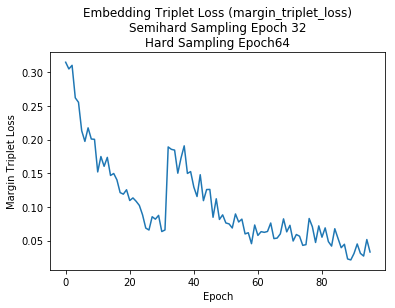

In [11]:
plt.plot(training_data)
plt.title("Embedding Triplet Loss (margin_triplet_loss)\nSemihard Sampling Epoch 32\nHard Sampling Epoch64")
plt.ylabel('Margin Triplet Loss')
plt.xlabel('Epoch')
plt.show()

In [12]:
# Get Features
# Load the model without retraining:
ver = 'benchmark_nasnet_triplet'

model = build_nasnet()
model_name = 'triplet_semihard_margin_{}.keras'.format(96)

print('model built')


model.load_weights(os.path.join('data', 'models', ver, model_name))
print('weights loaded')

# model = multi_gpu_model(model, gpus=6)
model.compile(optimizer=Adam(lr=0.0001, decay=0.0005),  loss='mean_squared_error')


batchsize = 12
train_gen = get_batches(train_dir, batch_size=batchsize)
val_gen = get_batches(val_dir, batch_size=batchsize)
test_gen = get_batches(test_dir, batch_size=batchsize)

train_embedding = model.predict_generator(train_gen, max_queue_size=1, workers=1, verbose=1)
val_embedding = model.predict_generator(val_gen, max_queue_size=1, workers=1, verbose=1)
test_embeddings = model.predict_generator(test_gen, max_queue_size=1, workers=1, verbose=1)



model built
weights loaded
Found 15702 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.
6644/6644 [==============================] - 5991s 902ms/step


In [17]:
# make a linear svm
from sklearn.svm import SVC

print(train_gen.classes)

clf=SVC(probability=True, verbose=True, kernel='linear')
clf.fit(train_embedding, train_gen.classes)
print()
print('linear svm train accuracy', clf.score(train_embedding, train_gen.classes))
print('linear svm validation accuracy:', clf.score(val_embedding, val_gen.classes))

[0 0 0 ... 9 9 9]
[LibSVM]
linear svm train accuracy 0.9941408737740415
linear svm validation accuracy: 0.9892889021124666


In [18]:
# make confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          verbose=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if verbose:
            print("Normalized confusion matrix")
    else:
        if verbose:
            print('Confusion matrix, without normalization')

    if verbose:
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


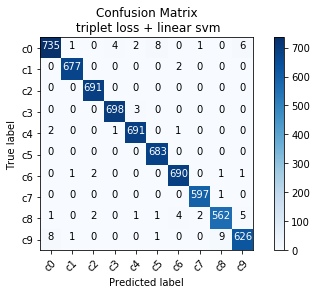

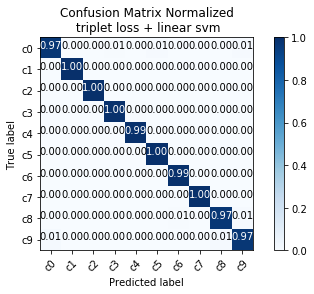

In [19]:
labels = os.listdir(train_dir)
labels.sort()
print(labels)

pred_linear = clf.predict(val_embedding)
lin_cf_mat = confusion_matrix(pred_linear, val_gen.classes)
plot_confusion_matrix(lin_cf_mat, labels,
                          normalize=False,
                          title='Confusion Matrix\n triplet loss + linear svm',
                          cmap=plt.cm.Blues)
plt.show()

plot_confusion_matrix(lin_cf_mat, labels,
                          normalize=True,
                          title='Confusion Matrix Normalized\n triplet loss + linear svm',
                          cmap=plt.cm.Blues)
plt.show()

In [21]:
# Test set predictions
print('svm predicting on {} test samples'.format(len(test_embeddings)))
pred = clf.predict_proba(test_embeddings)
print('prediction complete')

model_path = 'data/models/'+ver+'/'

# save to CSV
def do_clip(arr, mx): return np.clip(arr, (1-mx)/9, mx)
sub = do_clip(pred,1)
classes = sorted(train_gen.class_indices, key=train_gen.class_indices.get)
submission = pd.DataFrame(sub, columns=classes)
submission.insert(0, 'img', [a[5:] for a in test_gen.filenames])
submission.head()

csv_filepath = os.path.join(model_path, 'nasnet_margin-tripletloss_svm.csv')
submission.to_csv(csv_filepath, index=False)
print('csv saved at', csv_filepath)

svm predicting on 79726 test samples
prediction complete
csv saved at data/models/benchmark_nasnet_triplet/nasnet_margin-tripletloss_svm.csv


In [22]:
# Train using Batch Triplet Loss
model_bac = build_nasnet()
model = multi_gpu_model(model_bac, gpus=6)

model.compile(optimizer=Adam(lr=0.0001, decay=0.0005),  loss=batch_triplet_loss)

ver = 'benchmark_triplet_batchloss'
model_path = 'data/models/'+ver+'/'
if not os.path.exists(model_path):
    os.makedirs(model_path)


num_epoch = 32
num_triplets = batch_size*(300//batch_size) #300 #batch_size*10 # must be an integer multiple
pool = mp.Pool(processes=2) # change this to the number of cores your computer has
sampler = Sampler(pool, batch_size, num_triplets,  mode='random')


train_gen = sampler.get_generator()
training_data = []

epoch = 0
for i in range(num_epoch):
    h = model.fit_generator(train_gen, steps_per_epoch=num_triplets//(batch_size//3), epochs=epoch+1, initial_epoch=epoch,
    max_queue_size=1, callbacks=None)#get_callbacks(model_path))
    sampler.resample()
    training_data += h.history['loss']
    epoch += 1

sampler = Sampler(pool, batch_size, num_triplets,  mode='semihard')
# val_sampler
train_gen = sampler.get_generator()

for i in range(num_epoch):
    h = model.fit_generator(train_gen, steps_per_epoch=num_triplets//(batch_size//3), epochs=epoch+1, initial_epoch=epoch,
    max_queue_size=1, callbacks=None)#get_callbacks(model_path))
    sampler.resample()
    training_data += h.history['loss']
    epoch += 1
    
sampler = Sampler(pool, batch_size, num_triplets,  mode='hard')
train_gen = sampler.get_generator()

for i in range(num_epoch):
    h = model.fit_generator(train_gen, steps_per_epoch=num_triplets//(batch_size//3), epochs=epoch+1, initial_epoch=epoch,
    max_queue_size=1, callbacks=None)#get_callbacks(model_path))
    sampler.resample()
    training_data += h.history['loss']
    epoch += 1

model_name = 'triplet_semihard_batch_{}.keras'.format(epoch)
model_bac.save_weights(os.path.join(model_path, model_name))

/home/okon/anaconda2/envs/newtf3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
30/30 [==============================] - 194s 6s/step - loss: 0.1746
Epoch 2/2
30/30 [==============================] - 88s 3s/step - loss: 0.1592
Epoch 3/3
30/30 [==============================] - 89s 3s/step - loss: 0.1606
Epoch 4/4
30/30 [==============================] - 88s 3s/step - loss: 0.1521
Epoch 5/5
30/30 [==============================] - 88s 3s/step - loss: 0.1462
Epoch 6/6
30/30 [==============================] - 88s 3s/step - loss: 0.1339
Epoch 7/7
30/30 [==============================] - 87s 3s/step - loss: 0.1355
Epoch 8/8
30/30 [==============================] - 88s 3s/step - loss: 0.1075
Epoch 9/9
30/30 [==============================] - 88s 3s/step - loss: 0.0935
Epoch 10/10
30/30 [==============================] - 89s 3s/step - loss: 0.0870
Epoch 11/11
30/30 [==============================] - 88s 3s/step - loss: 0.0728
Epoch 12/12
30/30 [==============================] - 88s 3s/step - loss: 0.0681
Epoch 13/13
30/30 [==============================] - 88s 

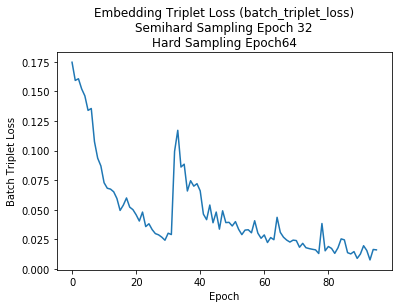

In [23]:
plt.plot(training_data)
plt.title("Embedding Triplet Loss (batch_triplet_loss)\nSemihard Sampling Epoch 32\nHard Sampling Epoch64")
plt.ylabel('Batch Triplet Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# import gc
# gc.collect()

In [24]:
# Load the model without retraining:
model = build_nasnet(dropout=False, trainable=False)
# model.load_weights(os.path.join(model_path, 'triplet_semihard_{}.keras'.format(epoch)))
model.load_weights(os.path.join('data', 'models', ver, model_name))

# model = multi_gpu_model(model, gpus=6)
model.compile(optimizer=Adam(lr=0.0001, decay=0.0005),  loss='mean_squared_error')


batchsize = 12
train_gen = get_batches(train_dir, batch_size=batchsize)
val_gen = get_batches(val_dir, batch_size=batchsize)
test_gen = get_batches(test_dir, batch_size=batchsize)

train_embedding = model.predict_generator(train_gen, max_queue_size=1, workers=1, verbose=1)
val_embedding = model.predict_generator(val_gen, max_queue_size=1, workers=1, verbose=1)
test_embeddings = model.predict_generator(test_gen, max_queue_size=1, workers=1, verbose=1)
# model.summary()

Found 15702 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.
6644/6644 [==============================] - 6094s 917ms/step


In [25]:
# make a linear svm
from sklearn.svm import SVC

print(train_gen.classes)

clf=SVC(probability=True, verbose=True, kernel='linear')
clf.fit(train_embedding, train_gen.classes)
print()
print('linear svm train accuracy', clf.score(train_embedding, train_gen.classes))
print('linear svm validation accuracy:', clf.score(val_embedding, val_gen.classes))



[0 0 0 ... 9 9 9]
[LibSVM]
linear svm train accuracy 0.9835689721054642
linear svm validation accuracy: 0.9809580481999405


['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


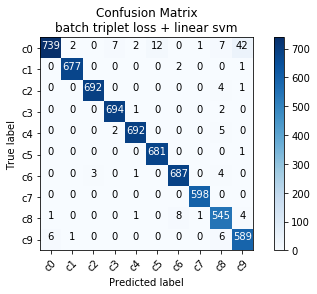

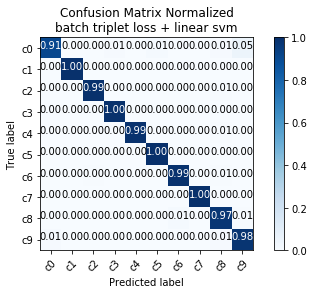

In [26]:
# plot confusion
labels = os.listdir(train_dir)
labels.sort()
print(labels)

pred_linear = clf.predict(val_embedding)
lin_cf_mat = confusion_matrix(pred_linear, val_gen.classes)
plot_confusion_matrix(lin_cf_mat, labels,
                          normalize=False,
                          title='Confusion Matrix\nbatch triplet loss + linear svm',
                          cmap=plt.cm.Blues)
plt.show()

plot_confusion_matrix(lin_cf_mat, labels,
                          normalize=True,
                          title='Confusion Matrix Normalized\nbatch triplet loss + linear svm',
                          cmap=plt.cm.Blues)
plt.show()


In [27]:
# Test set predictions
print('svm predicting on {} test samples'.format(len(test_embeddings)))
pred = clf.predict_proba(test_embeddings)
print('prediction complete')

# save to CSV
def do_clip(arr, mx): return np.clip(arr, (1-mx)/9, mx)
sub = do_clip(pred,1)
classes = sorted(train_gen.class_indices, key=train_gen.class_indices.get)
submission = pd.DataFrame(sub, columns=classes)
submission.insert(0, 'img', [a[5:] for a in test_gen.filenames])
submission.head()

csv_filepath = os.path.join(model_path, 'nasnet_batch-tripletloss_svm.csv')
submission.to_csv(csv_filepath, index=False)
print('csv saved at', csv_filepath)

svm predicting on 79726 test samples
prediction complete
csv saved at data/models/benchmark_triplet_batchloss/nasnet_batch-tripletloss_svm.csv


In [28]:
model_bac = build_nasnet()
model = multi_gpu_model(model_bac, gpus=6)

model.compile(optimizer=Adam(lr=0.0001, decay=0.0005),  loss=naive_triplet_loss)

ver = 'benchmark_triplet_naive'
model_path = 'data/models/'+ver+'/'
if not os.path.exists(model_path):
    os.makedirs(model_path)


num_epoch = 32
num_triplets = batch_size*(300//batch_size) #300 #batch_size*10 # must be an integer multiple
pool = mp.Pool(processes=2) # change this to the number of cores your computer has
sampler = Sampler(pool, batch_size, num_triplets,  mode='random')


train_gen = sampler.get_generator()
training_data = []

epoch = 0
for i in range(num_epoch):
    h = model.fit_generator(train_gen, steps_per_epoch=num_triplets//(batch_size//3), epochs=epoch+1, initial_epoch=epoch,
    max_queue_size=1, callbacks=None)#get_callbacks(model_path))
    sampler.resample()
    training_data += h.history['loss']
    epoch += 1

sampler = Sampler(pool, batch_size, num_triplets,  mode='semihard')
# val_sampler
train_gen = sampler.get_generator()

for i in range(num_epoch):
    h = model.fit_generator(train_gen, steps_per_epoch=num_triplets//(batch_size//3), epochs=epoch+1, initial_epoch=epoch,
    max_queue_size=1, callbacks=None)#get_callbacks(model_path))
    sampler.resample()
    training_data += h.history['loss']
    epoch += 1
    
sampler = Sampler(pool, batch_size, num_triplets,  mode='hard')
train_gen = sampler.get_generator()

for i in range(num_epoch):
    h = model.fit_generator(train_gen, steps_per_epoch=num_triplets//(batch_size//3), epochs=epoch+1, initial_epoch=epoch,
    max_queue_size=1, callbacks=None)#get_callbacks(model_path))
    sampler.resample()
    training_data += h.history['loss']
    epoch += 1

model_name = 'triplet_semihard_naive_{}.keras'.format(epoch)
model_bac.save_weights(os.path.join(model_path, model_name))



/home/okon/anaconda2/envs/newtf3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
30/30 [==============================] - 230s 8s/step - loss: 0.3184
Epoch 2/2
30/30 [==============================] - 91s 3s/step - loss: 0.3310
Epoch 3/3
30/30 [==============================] - 91s 3s/step - loss: 0.3022
Epoch 4/4
30/30 [==============================] - 90s 3s/step - loss: 0.2906
Epoch 5/5
30/30 [==============================] - 90s 3s/step - loss: 0.3048
Epoch 6/6
30/30 [==============================] - 90s 3s/step - loss: 0.2109
Epoch 7/7
30/30 [==============================] - 89s 3s/step - loss: 0.2292
Epoch 8/8
30/30 [==============================] - 89s 3s/step - loss: 0.1765
Epoch 9/9
30/30 [==============================] - 90s 3s/step - loss: 0.1083
Epoch 10/10
30/30 [==============================] - 91s 3s/step - loss: 0.1044
Epoch 11/11
30/30 [==============================] - 90s 3s/step - loss: 0.0144
Epoch 12/12
30/30 [==============================] - 90s 3s/step - loss: 0.0620
Epoch 13/13
30/30 [==============================] - 89s 

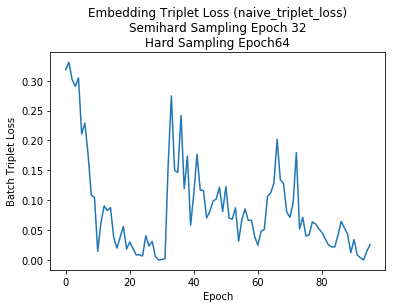

In [29]:
plt.plot(training_data)
plt.title("Embedding Triplet Loss (naive_triplet_loss)\nSemihard Sampling Epoch 32\nHard Sampling Epoch64")
plt.ylabel('Batch Triplet Loss')
plt.xlabel('Epoch')
plt.show()

In [30]:
# Load the model without retraining:
model = build_nasnet(dropout=False, trainable=False)
# model.load_weights(os.path.join(model_path, 'triplet_semihard_{}.keras'.format(epoch)))
ver = 'benchmark_triplet_naive'
model.load_weights(os.path.join('data', 'models', ver, model_name))


# model = multi_gpu_model(model, gpus=6)
model.compile(optimizer=Adam(lr=0.0001, decay=0.0005),  loss='mean_squared_error')



batchsize = 12
train_gen = get_batches(train_dir, batch_size=batchsize)
val_gen = get_batches(val_dir, batch_size=batchsize)
test_gen = get_batches(test_dir, batch_size=batchsize)

train_embedding = model.predict_generator(train_gen, max_queue_size=1, workers=1, verbose=1)
val_embedding = model.predict_generator(val_gen, max_queue_size=1, workers=1, verbose=1)
test_embeddings = model.predict_generator(test_gen, max_queue_size=1, workers=1, verbose=1)

Found 15702 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.
6644/6644 [==============================] - 6177s 930ms/step


In [31]:
# make a linear svm
from sklearn.svm import SVC


print(train_gen.classes)

clf=SVC(probability=True, verbose=True, kernel='linear')
clf.fit(train_embedding, train_gen.classes)
print()
print('linear svm train accuracy', clf.score(train_embedding, train_gen.classes))
print('linear svm validation accuracy:', clf.score(val_embedding, val_gen.classes))

[0 0 0 ... 9 9 9]
[LibSVM]
linear svm train accuracy 0.9449114762450643
linear svm validation accuracy: 0.9397500743826243


['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


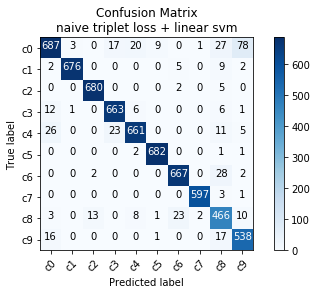

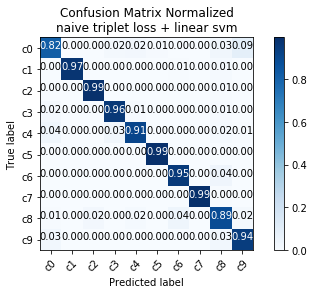

In [32]:
# plot confusion
labels = os.listdir(train_dir)
labels.sort()
print(labels)

pred_linear = clf.predict(val_embedding)
lin_cf_mat = confusion_matrix(pred_linear, val_gen.classes)
plot_confusion_matrix(lin_cf_mat, labels,
                          normalize=False,
                          title='Confusion Matrix\nnaive triplet loss + linear svm',
                          cmap=plt.cm.Blues)
plt.show()

plot_confusion_matrix(lin_cf_mat, labels,
                          normalize=True,
                          title='Confusion Matrix Normalized\nnaive triplet loss + linear svm',
                          cmap=plt.cm.Blues)
plt.show()

In [33]:
# Test set predictions
print('svm predicting on {} test samples'.format(len(test_embeddings)))
pred = clf.predict_proba(test_embeddings)
print('prediction complete')

# save to CSV
def do_clip(arr, mx): return np.clip(arr, (1-mx)/9, mx)
sub = do_clip(pred,1)
classes = sorted(train_gen.class_indices, key=train_gen.class_indices.get)
submission = pd.DataFrame(sub, columns=classes)
submission.insert(0, 'img', [a[5:] for a in test_gen.filenames])
submission.head()

csv_filepath = os.path.join(model_path, 'nasnet_naive-tripletloss_svm.csv')
submission.to_csv(csv_filepath, index=False)
print('csv saved at', csv_filepath)

svm predicting on 79726 test samples
prediction complete
csv saved at data/models/benchmark_triplet_naive/nasnet_naive-tripletloss_svm.csv


In [34]:
recombine(train_dir, val_dir)